## 0. Data Truncation: 2007-2025 Training Period

The full dataset covers ~1990-2025 (35 years). For training, we'll use only the 2007-2025 period (~18.3 years) to focus on more recent market dynamics.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Truncate dataset to 2007-2025 period
print('=' * 80)
print('Data Truncation: 2007-2025 Period')
print('=' * 80)

# Load full dataset first to understand it
df_full = pd.read_csv('../data/hull-tactical-market-prediction/train_cleaned.csv')
print(f'\nFull dataset: {len(df_full)} trading days (~{len(df_full)/252:.1f} years)')

# Calculate cutoff for 2007-2025 period
# Target: 4625 trading days (~18.35 years)
target_days = 4625
cutoff_date_id = len(df_full) - target_days

print(f'\nCutoff calculation:')
print(f'  Start from date_id: {cutoff_date_id}')
print(f'  Training days: {target_days} (~{target_days/252:.2f} years)')
print(f'  Estimated period: 2007-01 to 2025-06')

# Filter and reset date_id
df_train = df_full[df_full['date_id'] >= cutoff_date_id].copy()
df_train['date_id'] = df_train['date_id'] - cutoff_date_id

print(f'\nFiltered training dataset:')
print(f'  Shape: {df_train.shape}')
print(f'  Date ID range: {df_train["date_id"].min()} - {df_train["date_id"].max()}')

# Save truncated dataset
output_path = '../data/hull-tactical-market-prediction/train_2007_2025.csv'
df_train.to_csv(output_path, index=False)
print(f'\n✓ Saved to: {output_path}')

print('=' * 80)

Data Truncation: 2007-2025 Period

Full dataset: 8841 trading days (~35.1 years)

Cutoff calculation:
  Start from date_id: 4216
  Training days: 4625 (~18.35 years)
  Estimated period: 2007-01 to 2025-06

Filtered training dataset:
  Shape: (4625, 98)
  Date ID range: 0 - 4624

✓ Saved to: ../data/hull-tactical-market-prediction/train_2007_2025.csv


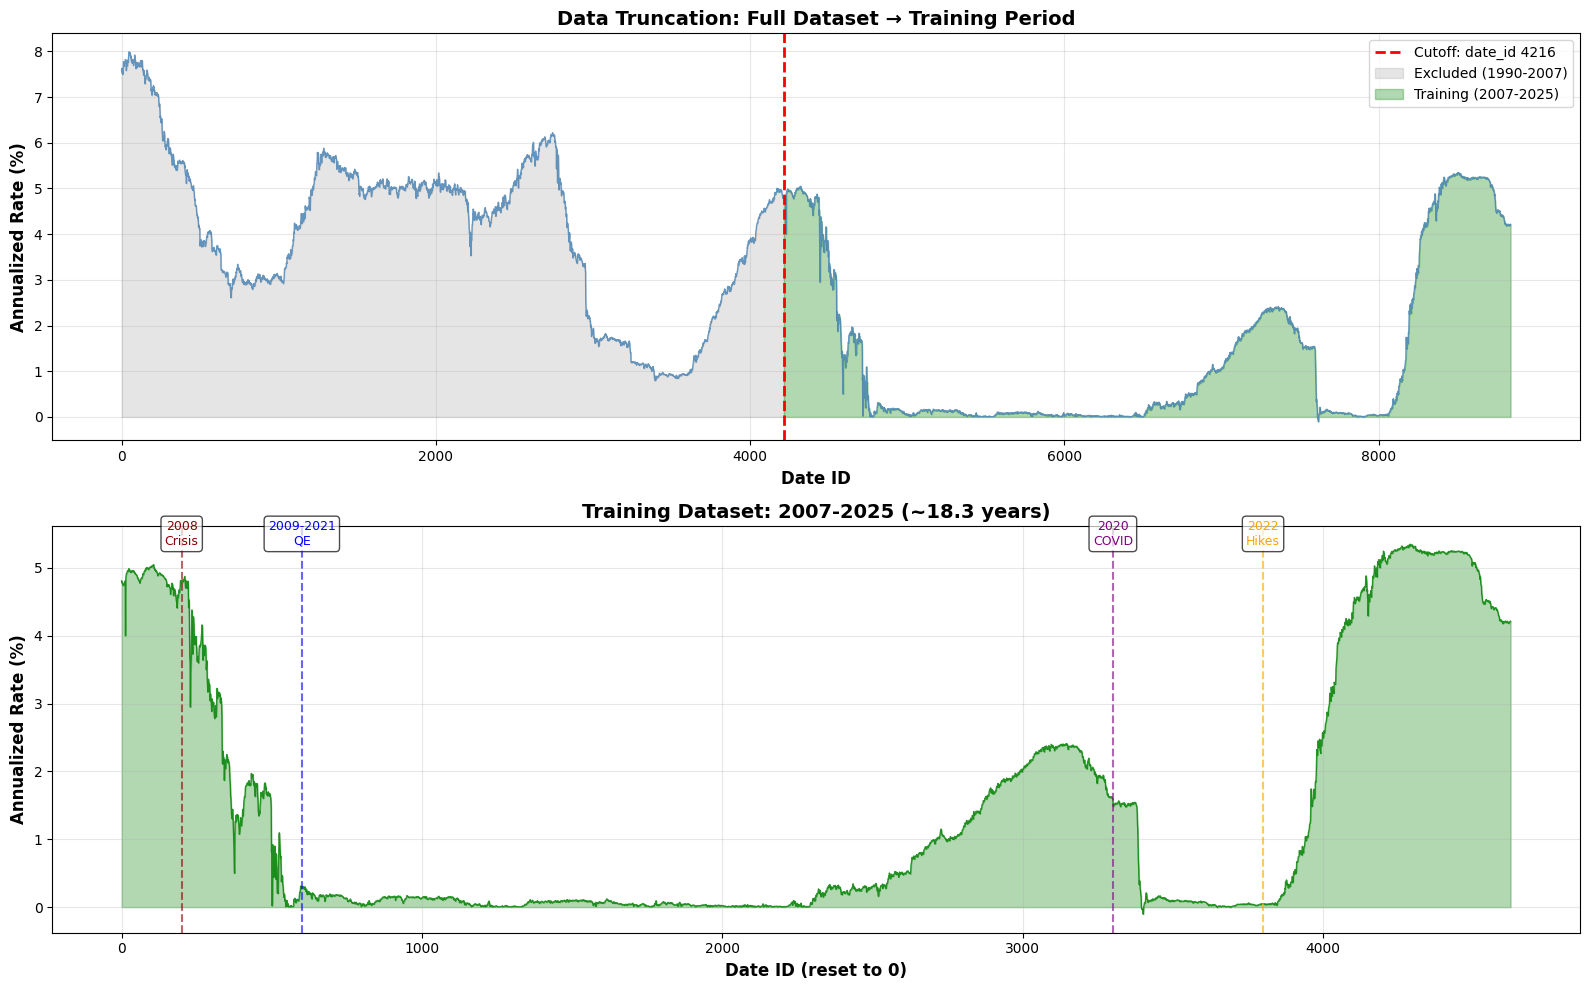


✓ Visualization saved


In [6]:
# Visualize the truncation
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Calculate rates for visualization
df_full['annual_rf_rate'] = df_full['risk_free_rate'] * 252 * 100
df_train['annual_rf_rate'] = df_train['risk_free_rate'] * 252 * 100

# Panel 1: Full dataset with cutoff
axes[0].plot(df_full['date_id'], df_full['annual_rf_rate'], linewidth=1, alpha=0.8, color='steelblue')
axes[0].axvline(x=cutoff_date_id, color='red', linestyle='--', linewidth=2, label=f'Cutoff: date_id {cutoff_date_id}')
axes[0].fill_between(df_full['date_id'], 0, df_full['annual_rf_rate'], 
                      where=(df_full['date_id'] < cutoff_date_id), alpha=0.2, color='gray', label='Excluded (1990-2007)')
axes[0].fill_between(df_full['date_id'], 0, df_full['annual_rf_rate'], 
                      where=(df_full['date_id'] >= cutoff_date_id), alpha=0.3, color='green', label='Training (2007-2025)')
axes[0].set_xlabel('Date ID', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Annualized Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Data Truncation: Full Dataset → Training Period', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Panel 2: Training dataset only
axes[1].plot(df_train['date_id'], df_train['annual_rf_rate'], linewidth=1, alpha=0.8, color='green')
axes[1].fill_between(df_train['date_id'], 0, df_train['annual_rf_rate'], alpha=0.3, color='green')
axes[1].set_xlabel('Date ID (reset to 0)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Annualized Rate (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Training Dataset: 2007-2025 (~18.3 years)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Add key period markers
events = [(200, '2008\nCrisis', 'darkred'), (600, '2009-2021\nQE', 'blue'), 
          (3300, '2020\nCOVID', 'purple'), (3800, '2022\nHikes', 'orange')]
for date_id, label, color in events:
    axes[1].axvline(x=date_id, color=color, linestyle='--', alpha=0.6, linewidth=1.5)
    axes[1].text(date_id, axes[1].get_ylim()[1] * 0.95, label, rotation=0, ha='center', 
                fontsize=9, color=color, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

print('\n✓ Visualization saved')

## 1. Data Quality Analysis

Analyze missing values and outliers in the 2007-2025 training dataset.

## 0.1 Data Splitting for Ensemble Strategy

Create two specialized datasets for modeling:
1. **`train_no_missing_2007_2025.csv`**: Long history (2007-2025), stable features only (drop columns with missing values).
2. **`train_2018_2025.csv`**: Recent history (2018-2025), all features (no missing values in this period).

In [ ]:
# Identify split point and missing columns
print('=' * 80)
print('DATA SPLITTING FOR ENSEMBLE STRATEGY')
print('=' * 80)

# 1. Identify columns with missing values in the 2007-2025 dataset
missing_cols = df_train.columns[df_train.isnull().any()].tolist()
print(f'\nColumns with missing values ({len(missing_cols)}): {missing_cols}')

# 2. Find the first date_id where NO column is missing
last_missing_indices = {}
for col in missing_cols:
    last_idx = df_train[df_train[col].isnull()].index.max()
    last_missing_indices[col] = last_idx

cutoff_idx = max(last_missing_indices.values()) + 1
cutoff_date_id = df_train.loc[cutoff_idx, 'date_id']

print(f'\nSplit Point Analysis:')
print(f'  Cutoff Index: {cutoff_idx}')
print(f'  Cutoff Date ID: {cutoff_date_id} (~2018)')

# 3. Create Dataset A: Stable Features (2007-2025)
df_stable = df_train.drop(columns=missing_cols).copy()
output_path_stable = '../data/hull-tactical-market-prediction/train_no_missing_2007_2025.csv'
df_stable.to_csv(output_path_stable, index=False)

print(f'\nDataset A (Stable Features):')
print(f'  Path: {output_path_stable}')
print(f'  Shape: {df_stable.shape}')
print(f'  Missing values: {df_stable.isnull().sum().sum()}')

# 4. Create Dataset B: All Features (2018-2025)
df_recent = df_train.iloc[cutoff_idx:].copy()
output_path_recent = '../data/hull-tactical-market-prediction/train_2018_2025.csv'
df_recent.to_csv(output_path_recent, index=False)

print(f'\nDataset B (All Features, Recent):')
print(f'  Path: {output_path_recent}')
print(f'  Shape: {df_recent.shape}')
print(f'  Missing values: {df_recent.isnull().sum().sum()}')

print('=' * 80)

In [7]:
# Comprehensive data quality check
print('=' * 80)
print('DATA QUALITY ANALYSIS')
print('=' * 80)

print(f'\nDataset shape: {df_train.shape}')
print(f'Date range: {df_train["date_id"].min()} - {df_train["date_id"].max()}')

# 1.1 Missing values
print('\n--- Missing Values ---')
missing_counts = df_train.isnull().sum()
missing_pct = (missing_counts / len(df_train)) * 100
missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing_Count': missing_counts.values,
    'Missing_Percent': missing_pct.values
}).sort_values('Missing_Count', ascending=False)

cols_with_missing = missing_df[missing_df['Missing_Count'] > 0]
print(f'Columns with missing values: {len(cols_with_missing)}')
print('\nTop 10 columns with most missing:')
print(cols_with_missing.head(10).to_string(index=False))

# Missing by feature category
print('\n--- Missing Values by Category ---')
for prefix in ['D', 'E', 'I', 'M', 'P', 'S', 'V']:
    cols = [col for col in df_train.columns if col.startswith(prefix)]
    if cols:
        total_missing = df_train[cols].isnull().sum().sum()
        total_cells = len(df_train) * len(cols)
        pct = (total_missing / total_cells) * 100
        print(f'{prefix}-features: {total_missing:,} missing ({pct:.2f}%) across {len(cols)} cols')

DATA QUALITY ANALYSIS

Dataset shape: (4625, 99)
Date range: 0 - 4624

--- Missing Values ---
Columns with missing values: 8

Top 10 columns with most missing:
Column  Missing_Count  Missing_Percent
    E7           2753        59.524324
   V10           1833        39.632432
    S3           1517        32.800000
    M1           1331        28.778378
   M14           1324        28.627027
   M13           1324        28.627027
    M6            827        17.881081
    V9            323         6.983784

--- Missing Values by Category ---
D-features: 0 missing (0.00%) across 9 cols
E-features: 2,753 missing (2.98%) across 20 cols
I-features: 0 missing (0.00%) across 9 cols
M-features: 4,806 missing (5.77%) across 18 cols
P-features: 0 missing (0.00%) across 13 cols
S-features: 1,517 missing (2.73%) across 12 cols
V-features: 2,156 missing (3.59%) across 13 cols


In [9]:
import numpy as np
import pandas as pd

# 1.2 Outlier analysis
print('\n--- Outlier Analysis (3*IQR rule) ---')

numeric_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
feature_cols = [col for col in numeric_cols if col not in exclude_cols]

outlier_summary = []
for col in feature_cols:
    non_null = df_train[col].dropna()
    if len(non_null) > 0:
        Q1 = non_null.quantile(0.25)
        Q3 = non_null.quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 3 * IQR
        upper = Q3 + 3 * IQR
        
        outliers = ((non_null < lower) | (non_null > upper)).sum()
        if outliers > 0:
            outlier_summary.append({
                'Column': col,
                'Outliers': outliers,
                'Pct': (outliers / len(non_null)) * 100
            })

outlier_df = pd.DataFrame(outlier_summary).sort_values('Outliers', ascending=False)
print(f'Columns with outliers: {len(outlier_df)}')
print('\nTop 10 columns with most outliers:')
print(outlier_df.head(10).to_string(index=False))

# 1.3 Target variable check
print('\n--- Target Variables ---')
for var in ['forward_returns', 'market_forward_excess_returns', 'risk_free_rate']:
    if var in df_train.columns:
        print(f'{var}: Mean={df_train[var].mean():.6f}, Std={df_train[var].std():.6f}, '
              f'Missing={df_train[var].isnull().sum()}')

print('\n' + '=' * 80)


--- Outlier Analysis (3*IQR rule) ---
Columns with outliers: 35

Top 10 columns with most outliers:
Column  Outliers       Pct
    D6      1105 23.891892
    D5       884 19.113514
    D8       663 14.335135
    D9       663 14.335135
   E12       527 11.394595
   E11       356  7.697297
    P6       334  7.221622
    S5       255  5.513514
    E4       225  4.864865
    D3       224  4.843243

--- Target Variables ---
forward_returns: Mean=0.000502, Std=0.010972, Missing=0
market_forward_excess_returns: Mean=0.000135, Std=0.010994, Missing=0
risk_free_rate: Mean=0.000055, Std=0.000072, Missing=0



## 1.3 Outlier Visualization

Visualizing outliers for the two datasets: `train_no_missing_2007_2025` and `train_2018_2025`.
Using 3*IQR rule to identify and highlight outliers in distribution and time series.

Datasets loaded successfully for visualization.
VISUALIZATION: TARGET VARIABLE


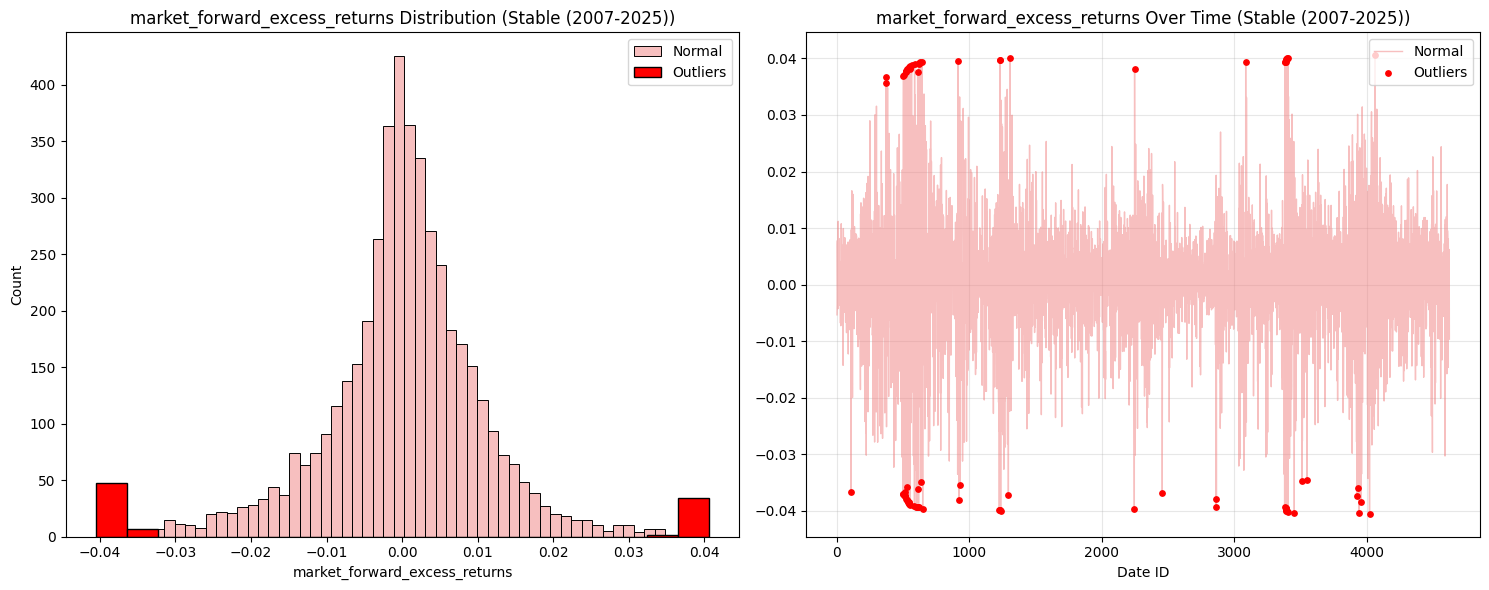

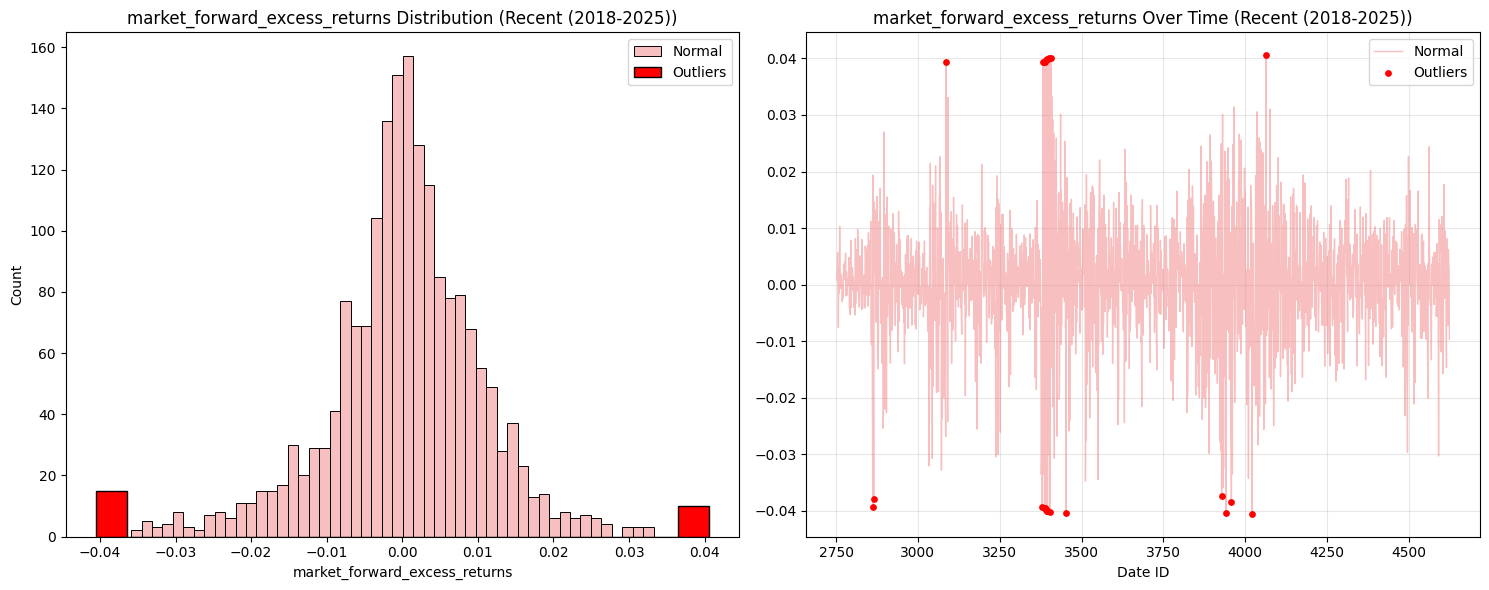


VISUALIZATION: TOP OUTLIER FEATURE (D6)


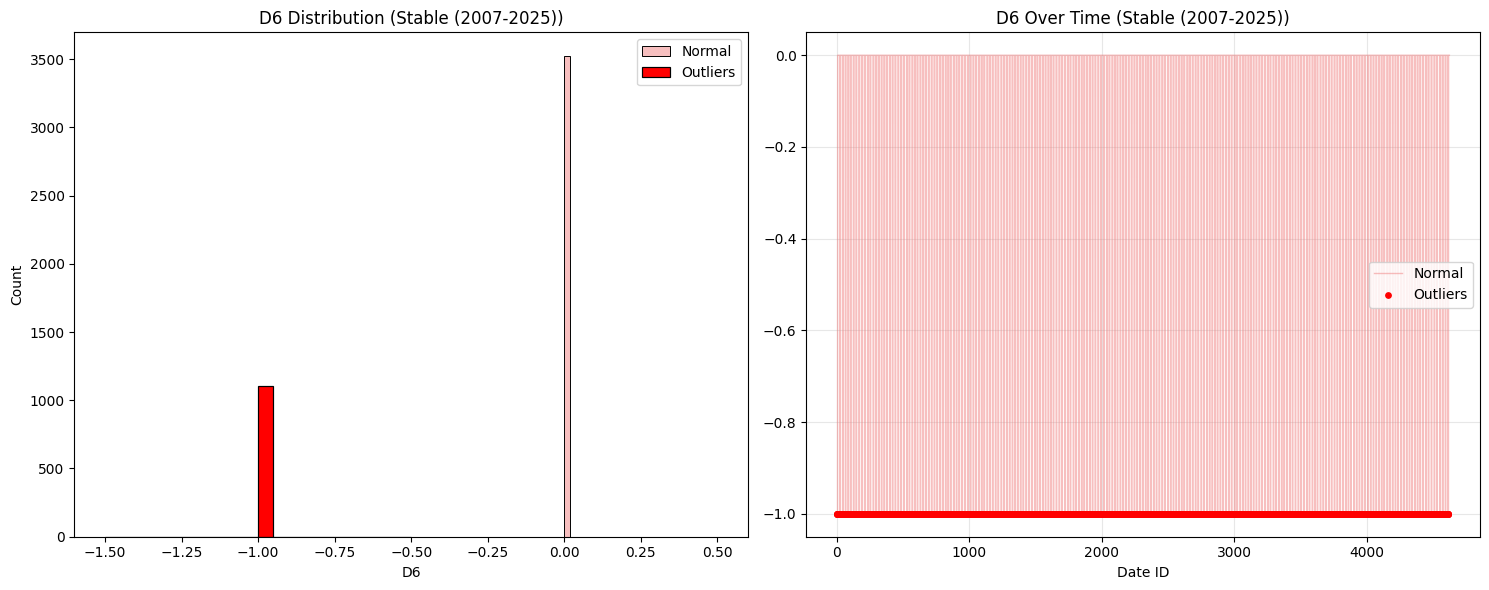

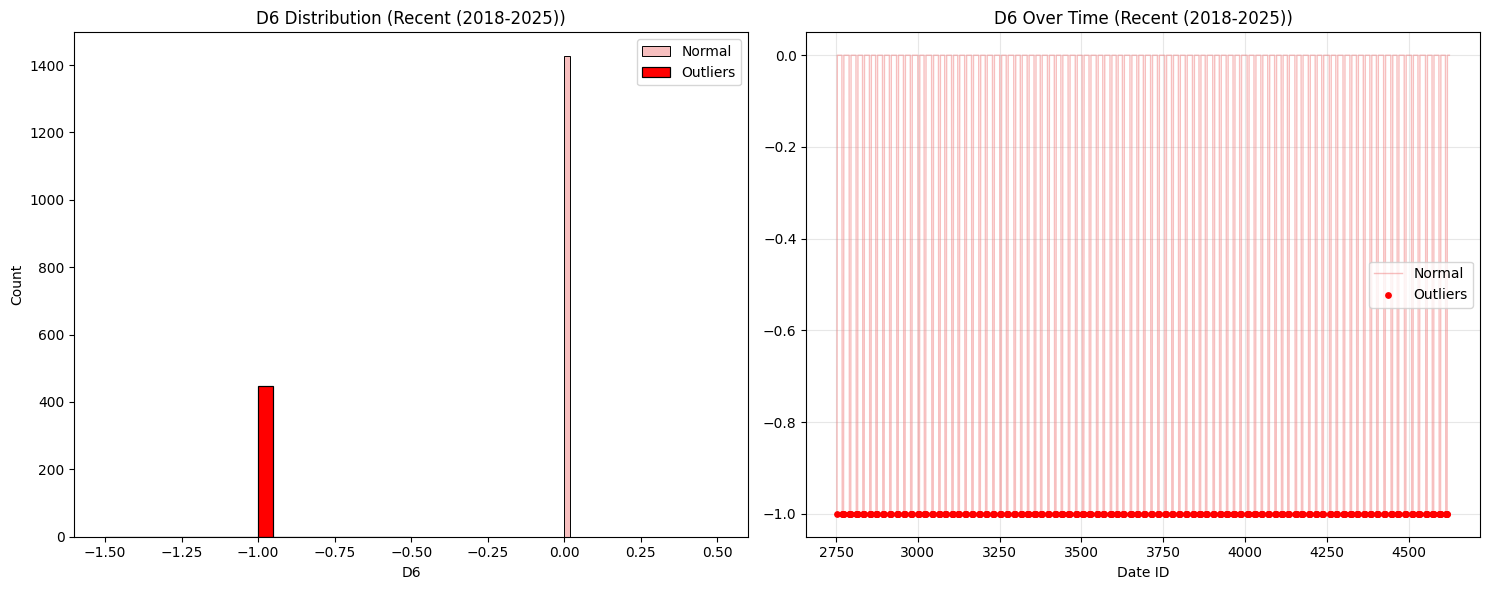

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_outliers(df, col, dataset_name):
    # Calculate outliers (3*IQR)
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    normal = df[(df[col] >= lower) & (df[col] <= upper)]
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 1. Histogram
    # Plot normal data
    sns.histplot(normal[col], color='lightcoral', label='Normal', ax=axes[0], bins=50, alpha=0.5)
    # Plot outliers (if any)
    if len(outliers) > 0:
        sns.histplot(outliers[col], color='red', label='Outliers', ax=axes[0], bins=20, alpha=1.0)
    
    axes[0].set_title(f'{col} Distribution ({dataset_name})')
    axes[0].legend()
    
    # 2. Time Series
    axes[1].plot(df['date_id'], df[col], color='lightcoral', alpha=0.5, label='Normal', linewidth=1)
    if len(outliers) > 0:
        axes[1].scatter(outliers['date_id'], outliers[col], color='red', s=15, label='Outliers', zorder=5)
    
    axes[1].set_title(f'{col} Over Time ({dataset_name})')
    axes[1].set_xlabel('Date ID')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Load the split datasets
try:
    df_stable = pd.read_csv('../data/hull-tactical-market-prediction/train_no_missing_2007_2025.csv')
    df_recent = pd.read_csv('../data/hull-tactical-market-prediction/train_2018_2025.csv')
    print("Datasets loaded successfully for visualization.")
except FileNotFoundError:
    # Fallback if running from root
    df_stable = pd.read_csv('data/hull-tactical-market-prediction/train_no_missing_2007_2025.csv')
    df_recent = pd.read_csv('data/hull-tactical-market-prediction/train_2018_2025.csv')
    print("Datasets loaded successfully (fallback path).")

# Visualize Target Variable
print('='*80)
print('VISUALIZATION: TARGET VARIABLE')
print('='*80)
plot_outliers(df_stable, 'market_forward_excess_returns', 'Stable (2007-2025)')
plot_outliers(df_recent, 'market_forward_excess_returns', 'Recent (2018-2025)')

# Visualize Top Outlier Feature (D6)
print('\n' + '='*80)
print('VISUALIZATION: TOP OUTLIER FEATURE (D6)')
print('='*80)
if 'D6' in df_stable.columns:
    plot_outliers(df_stable, 'D6', 'Stable (2007-2025)')
if 'D6' in df_recent.columns:
    plot_outliers(df_recent, 'D6', 'Recent (2018-2025)')

## 3. Global Winsorization (Outlier Treatment)

Apply **Global Winsorization** to ensure consistency across models:
1. **Common Features**: Calculate 1st/99th percentile bounds from the **Long History** dataset (`train_no_missing_2007_2025`). Apply these fixed bounds to **both** datasets. This ensures the 2018-2025 model understands "true" market extremes (e.g., 2008 crisis).
2. **Unique Features** (only in 2018-2025): Calculate bounds from the 2018-2025 dataset itself.

In [15]:
import numpy as np
import pandas as pd

print('=' * 80)
print('GLOBAL WINSORIZATION')
print('=' * 80)

# Load the split datasets
df_stable = pd.read_csv('../data/hull-tactical-market-prediction/train_no_missing_2007_2025.csv')
df_recent = pd.read_csv('../data/hull-tactical-market-prediction/train_2018_2025.csv')

print(f'Loaded datasets:')
print(f'  Stable (2007-2025): {df_stable.shape}')
print(f'  Recent (2018-2025): {df_recent.shape}')

# Identify columns
exclude_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
stable_feats = [col for col in df_stable.columns if col not in exclude_cols]
recent_feats = [col for col in df_recent.columns if col not in exclude_cols]

# Find common and unique features
common_feats = list(set(stable_feats) & set(recent_feats))
unique_feats = list(set(recent_feats) - set(stable_feats))

print(f'\nFeature Analysis:')
print(f'  Common features: {len(common_feats)} (Bounds from 2007-2025)')
print(f'  Unique features: {len(unique_feats)} (Bounds from 2018-2025)')

# 1. Calculate Global Bounds from Stable Dataset (2007-2025)
global_bounds = {}
print(f'\nCalculating global bounds from Stable dataset...')
for col in common_feats:
    p1 = df_stable[col].quantile(0.01)
    p99 = df_stable[col].quantile(0.99)
    global_bounds[col] = (p1, p99)

# 2. Apply Global Bounds to BOTH datasets
winsorized_count = 0
for col in common_feats:
    lower, upper = global_bounds[col]
    
    # Apply to Stable
    df_stable[col] = df_stable[col].clip(lower=lower, upper=upper)
    
    # Apply to Recent
    df_recent[col] = df_recent[col].clip(lower=lower, upper=upper)
    winsorized_count += 1

print(f'✓ Applied global bounds to {winsorized_count} common features in both datasets')

# 3. Handle Unique Features (Self-Winsorization for Recent dataset)
unique_winsorized = 0
for col in unique_feats:
    p1 = df_recent[col].quantile(0.01)
    p99 = df_recent[col].quantile(0.99)
    df_recent[col] = df_recent[col].clip(lower=p1, upper=p99)
    unique_winsorized += 1

print(f'✓ Applied self-bounds to {unique_winsorized} unique features in Recent dataset')

# Save Final Cleaned Datasets
path_stable_clean = '../data/hull-tactical-market-prediction/train_no_missing_2007_2025_cleaned.csv'
path_recent_clean = '../data/hull-tactical-market-prediction/train_2018_2025_cleaned.csv'

df_stable.to_csv(path_stable_clean, index=False)
df_recent.to_csv(path_recent_clean, index=False)

print(f'\nSaved Final Datasets:')
print(f'  Stable Cleaned: {path_stable_clean}')
print(f'  Recent Cleaned: {path_recent_clean}')
print('=' * 80)

GLOBAL WINSORIZATION
Loaded datasets:
  Stable (2007-2025): (4625, 90)
  Recent (2018-2025): (1872, 98)

Feature Analysis:
  Common features: 86 (Bounds from 2007-2025)
  Unique features: 8 (Bounds from 2018-2025)

Calculating global bounds from Stable dataset...
✓ Applied global bounds to 86 common features in both datasets
✓ Applied self-bounds to 8 unique features in Recent dataset

Saved Final Datasets:
  Stable Cleaned: ../data/hull-tactical-market-prediction/train_no_missing_2007_2025_cleaned.csv
  Recent Cleaned: ../data/hull-tactical-market-prediction/train_2018_2025_cleaned.csv
